In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as st
import functools


In [2]:
puntos = pd.read_csv('puntosguia4.csv', sep=";", decimal="," , names=('x','y') )
erro_sup = pd.read_csv('errores superiores.csv', sep=";", decimal=",", names=('errx','erry') )
erro_inf = pd.read_csv('errores inferiores.csv', sep=";", decimal=",", names=('errx','erry') )

In [3]:

# https://apps.automeris.io/wpd/
# https://arxiv.org/pdf/astro-ph/0012085.pdf


In [4]:
#Modelo
def Schechter(phi,x,alp,Mest):
    ym=(0.4*np.log(10.0)*phi*(10**(-0.4*(x-Mest)*(alp+1)))*np.exp(-10**(-0.4*(x-Mest))))
    return(ym)

#probabilidad a priori
#distribuciones uniformes
#ṕor que usa los intervalos de menor o mayor?

def priorr(P,A,M,Pmin,Pmax,Amin,Amax,Mmin,Mmax,n):
    PRO=1.*(P < Pmax) * (P > Pmin) * (A < Amax) * (A > Amin)* (M < Mmax) * (M > Mmin)
    NORM=(Pmax-Pmin)*(Amax-Amin)*(Mmax-Mmin)#aca no falta algo?
    PRO=PRO/NORM
    return(PRO)


#asumiendo errores gausianos calculo likehood
def likehood(x,y,sigma,phi,alp,Mest):
    ym=Schechter(phi,x,alp,Mest)
#    dif=y0-y
#    a=st.norm(loc=0,scale=sigma).pdf(dif)
    a=st.norm(loc=ym,scale=sigma).pdf(y)
    like=a.prod()
    return(like)

#probabilidad posterior
def posterior(x, y, P, A, M, sigma):    
    post = likehood(x, y, sigma, P, A, M) * prior(P,A,M)
    return(post)

#establezco las variables de una exepto el x,y,z
prior = functools.partial(priorr,Pmin=0.0,Pmax=4.0,Amin=-4.0,Amax=0.0,Mmin=-24.0,Mmax=-18.0,n=100)

sigma=abs((erro_sup['erry']-erro_inf['erry'])/2.0)

In [66]:
es=np.array(puntos['y'])-np.array(erro_inf['erry'])
ei=np.array(erro_sup['erry'])-np.array(puntos['y'])
es.sort()
ei.sort()

#plt.errorbar(puntos['x'],puntos['y'],yerr=(puntos['y']-erro_inf['erry'],erro_sup['erry']-puntos['y']))


[-5.77911637e-02 -1.79048799e-02 -1.06863425e-03  0.00000000e+00
  3.39584410e-06  2.24719717e-05  2.68134210e-05  5.76299331e-05
  7.86936136e-05  1.52309165e-04  1.58472561e-04  2.56224733e-04
  5.27929308e-04  7.63352611e-04  1.03955794e-03  1.65298321e-03
  1.67654592e-03  2.00206508e-03  2.10453201e-03  2.16432981e-03
  2.27378665e-03  2.43642539e-03  2.54876183e-03  2.55662554e-03
  2.63387157e-03  2.83832503e-03  3.17053825e-03  3.29129464e-03
  3.32126468e-03  3.46743040e-03  3.55193267e-03  3.71539323e-03
  3.93987089e-03  4.40740834e-03  4.63077429e-03  6.10223663e-03
  6.17002872e-03  6.24487491e-03  6.64897527e-03  9.06565238e-03
  1.18008603e-02  1.20802713e-02  1.50695946e-02  1.76804841e-02
  2.69329036e-02  4.91179069e-02  7.29717342e-02]


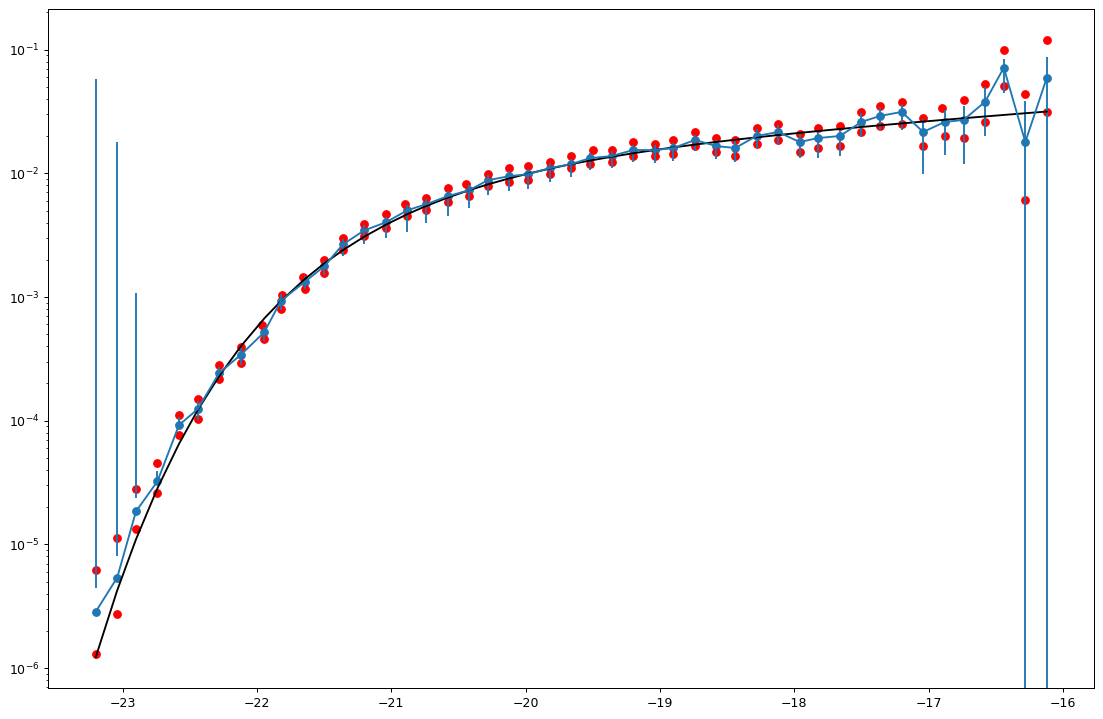

In [74]:
y=Schechter(0.0146,puntos['x'],-1.20,-20.83)
plt.figure(figsize=(15, 10), dpi=90) #dpi es la resolucion
plt.plot(puntos['x'],y,c='black')
plt.scatter(puntos['x'],puntos['y'])
plt.scatter(puntos['x'],erro_inf['erry'],color='red')
plt.scatter(erro_sup['errx'],erro_sup['erry'],color='red')
plt.errorbar(puntos['x'],puntos['y'],yerr=(ei,es))
plt.yscale('log')




In [22]:
likehood(x,y,sigma,0.0146,-1.20,-20.83)


1.6586442571747694e+107

In [78]:
Pmin=0.0
Pmax=1.0
Amin=-4.0
Amax=0.0
Mmin=(-24.0)
Mmax=(-18.0)

#defino los sigmas
PhiIn=0.002;AlpIn=0.2;MestIn=1.0
PROPOSAL = functools.partial(np.random.multivariate_normal, cov = [[PhiIn, 0 , 0], [0, AlpIn,0], [0,0,MestIn] ] )

#defino los datos
x=puntos['x']
y=puntos['y']

#CADENA DE MARKOV

Phicamino=[];Alpcamino=[];Mestcamino=[] 
#en mayuscula lo nuevo, en minuscula lo viejo.
#defino valores iniciales
#perdon compu
Npaso=30000
Nquemado=500
phi=0.7
alp=-3.0
mest=-22.0
#probabilidad de donde estoy
post=posterior(x,y, phi, alp, mest, sigma)
#calculo la cadena
for i in range(Npaso):
    #propongo un paso
    PHI,ALP,MEST=PROPOSAL([phi,alp,mest])
    #evaluo la probabilidad ahi
    POST=posterior(x,y, PHI, ALP, MEST, sigma)
    #me fijo si es mayor o menor a donde estoy parado
    if (post==0):
        acept= 1.
    else :
        acept = min(1., POST/post)
    #me fijo si la acepto o no
    RanAcept=np.random.rand()
    
    if (acept>RanAcept):
        phi=PHI
        alp=ALP
        mest=MEST
        post=posterior(x,y, phi, alp, mest, sigma)
    #guardo las variables de cada paso
    Phicamino.append(phi)
    Alpcamino.append(alp)
    Mestcamino.append(mest)
    
phiafuera = Phicamino[:Nquemado]
alpafuera = Alpcamino[:Nquemado]
mestafuera = Mestcamino[:Nquemado]

phidentro = Phicamino[Nquemado:]
alpdentro = Alpcamino[Nquemado:]
mestdentro = Mestcamino[Nquemado:]


/usr/lib64/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/usr/lib64/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


In [79]:
PHI_M=np.mean(Phicamino)
ALP_M=np.mean(Alpcamino)
MEST_M=np.mean(Mestcamino)

Text(0, 0.5, 'Mest')

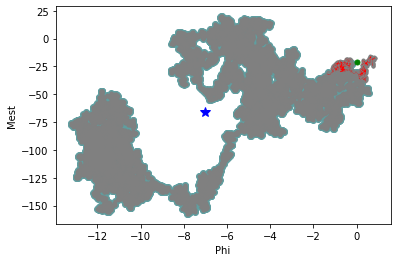

In [80]:
plt.plot(Phicamino, Mestcamino, marker='.',  lw = 0.2, color='gray')
plt.plot(phiafuera, mestafuera, marker='.', markersize=0., lw = 0.2, color='red')
plt.scatter(phidentro, mestdentro, color='cadetblue')
plt.plot(0.0146, -20.83, marker='o', markersize=5, color='g')
plt.plot(PHI_M, MEST_M, marker='*', markersize=10, color='b')
plt.xlabel('Phi')
plt.ylabel('Mest')
#plt.plot(par_a0_out, par_t0_out, marker='.', markersize=0., lw = 0.2, color='red')
#plt.scatter(par_a0_brn, par_t0_brn, color='cadetblue')

Text(0, 0.5, 'Mest')

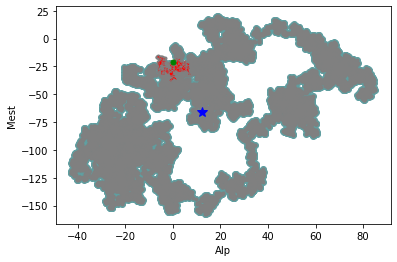

In [82]:
plt.plot(Alpcamino, Mestcamino, marker='.',  lw = 0.2, color='gray')
plt.plot(alpafuera, mestafuera, marker='.', markersize=0., lw = 0.2, color='red')
plt.scatter(alpdentro, mestdentro, color='cadetblue')
plt.plot(0.0146, -20.83, marker='o', markersize=5, color='g')
plt.plot(ALP_M, MEST_M, marker='*', markersize=10, color='b')
plt.xlabel('Alp')
plt.ylabel('Mest')
#plt.plot(par_a0_out, par_t0_out, marker='.', markersize=0., lw = 0.2, color='red')
#plt.scatter(par_a0_brn, par_t0_brn, color='cadetblue')